# GOAL
In this notebook we'll try to explore the rating of movies, analyze it over time and try to get some useful insights. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [68]:
mov = pd.read_csv("data/processed_movies.csv")
mov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33202 entries, 0 to 33201
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Wikipedia movie ID  33202 non-null  int64  
 1   freebase_ID         33202 non-null  object 
 2   Movie name          33202 non-null  object 
 3   Movie release date  33202 non-null  int64  
 4   Movie runtime       29091 non-null  float64
 5   Movie languages     33202 non-null  object 
 6   Movie countries     33202 non-null  object 
 7   Movie genres        33202 non-null  object 
 8   IMDB_ID             30817 non-null  object 
 9   averageRating       29267 non-null  float64
 10  numVotes            29267 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 2.8+ MB


In [69]:
# Separate the dataframe into those having a rating and those not having one
no_rat = mov.where(mov.averageRating.isnull())
print(no_rat.describe())
rat = mov.where(mov.averageRating.notnull())
print(rat.describe())

       Wikipedia movie ID  Movie release date  Movie runtime  averageRating  \
count        3.935000e+03         3935.000000    2381.000000            0.0   
mean         1.650405e+07         1962.675222      71.486958            NaN   
std          9.477519e+06           39.384322      52.892311            NaN   
min          4.434800e+04         1900.000000       1.000000            NaN   
25%          8.008406e+06         1919.000000      45.000000            NaN   
50%          1.490442e+07         1971.000000      71.000000            NaN   
75%          2.370397e+07         2004.000000      91.000000            NaN   
max          3.725731e+07         2016.000000     840.000000            NaN   

       numVotes  
count       0.0  
mean        NaN  
std         NaN  
min         NaN  
25%         NaN  
50%         NaN  
75%         NaN  
max         NaN  
       Wikipedia movie ID  Movie release date  Movie runtime  averageRating  \
count        2.926700e+04        29267.000000  

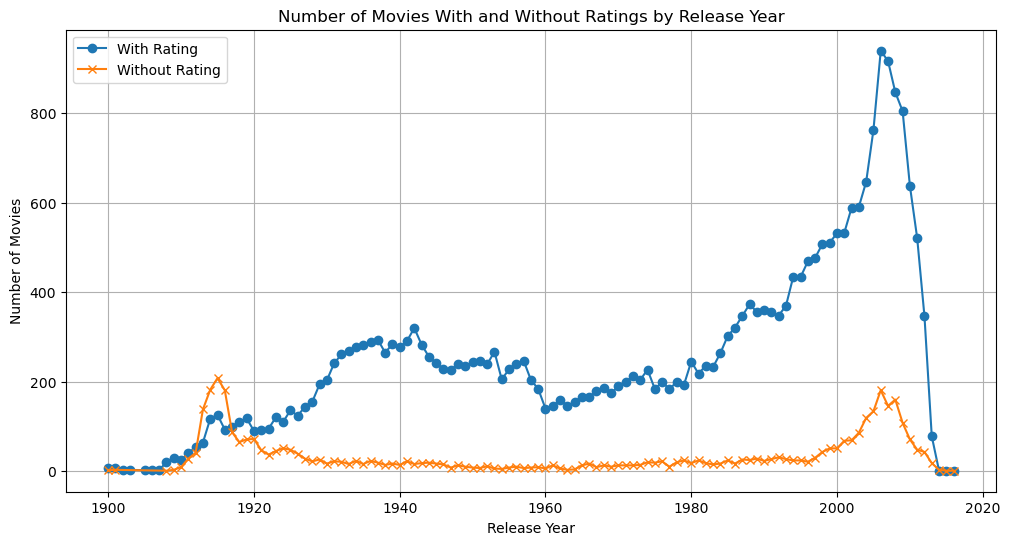

In [ ]:
# Group by release year and count movies with ratings
rat_per_year = rat.groupby('Movie release date')['averageRating'].count()

# Group by release year and count movies without ratings
no_rat_per_year = no_rat.groupby('Movie release date').size()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(rat_per_year.index, rat_per_year.values, label='With Rating', marker='o')
plt.plot(no_rat_per_year.index, no_rat_per_year.values, label='Without Rating', marker='x')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Number of Movies With and Without Ratings by Release Year')
plt.legend()
plt.grid()
plt.show()


We can see that there are a lot of movies without rating for years between 1912 and 1918 and later on around 2007. The first peak of missing ratings is quite problematic as there are more movies without rating than with, while the second is much less problematic since there are more movies that have a rating. 
We should take this into account later on when trying to draw conclusions. 

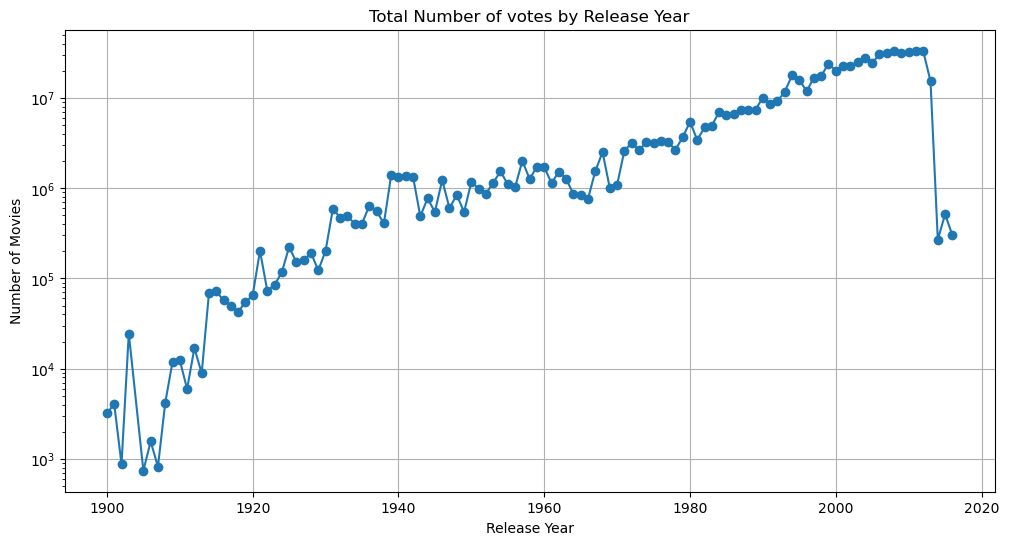

In [17]:
# Group by release year and count movies with ratings
votes_per_year = rat.groupby('Movie release date')['numVotes'].sum()


# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(votes_per_year.index, votes_per_year.values, marker='o')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.title('Total Number of votes by Release Year')
plt.grid()
plt.yscale('log')
plt.show()


Again we can see that the dataset is extremely inbalanced because we have far many votes for recent movies than before (NOTICE THE LOG SCALE)

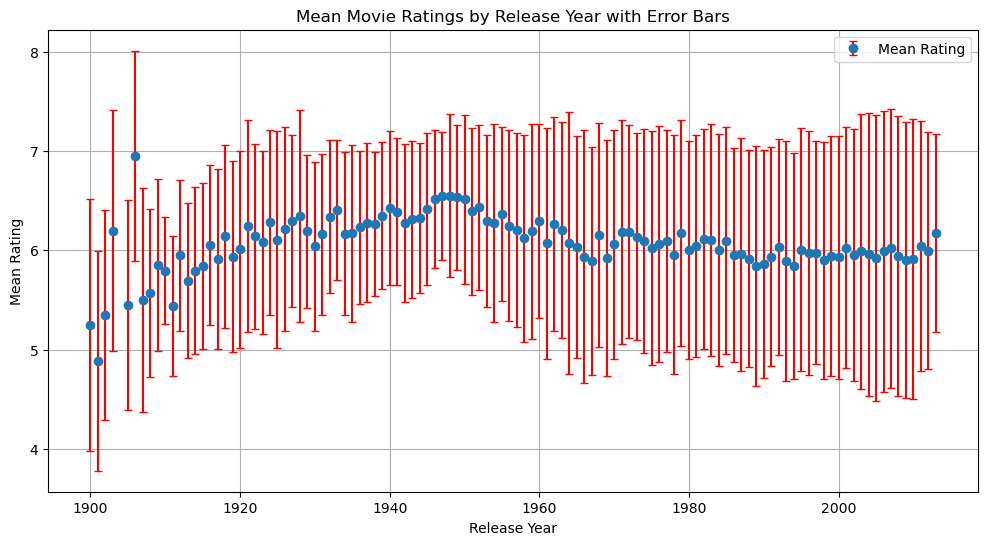

In [ ]:
# Group by release year and calculate mean and standard deviation
rating_stats = rat.groupby('Movie release date')['averageRating'].agg(['mean', 'std']).dropna()


# Extract years, means, and standard deviations
years = rating_stats.index
means = rating_stats['mean']
stds = rating_stats['std']

# Plot the mean ratings with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(years, means, yerr=stds, fmt='o', label='Mean Rating', ecolor='red', capsize=3)
plt.xlabel('Release Year')
plt.ylabel('Mean Rating')
plt.title('Mean Movie Ratings by Release Year with Error Bars')
plt.legend()
plt.grid()
plt.show()

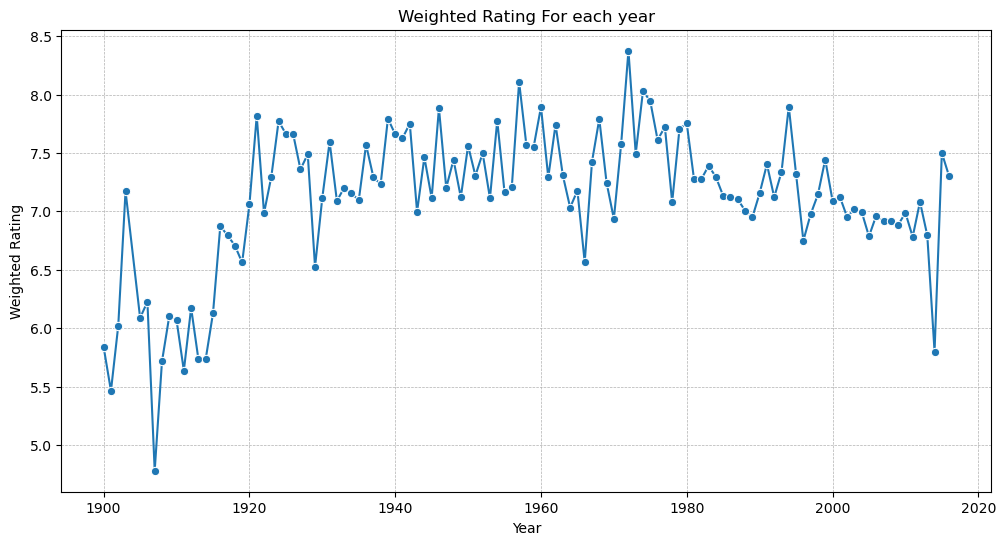

In [51]:
# Multiply rating by the number of votes for each movie
rat['rating_votes'] = rat['averageRating'] * rat['numVotes']

# Group by movie release year and calculate the mean of 'rating_votes'
average_rating_votes_per_year = rat.groupby('Movie release date')['rating_votes'].sum() / rat.groupby('Movie release date')['numVotes'].sum()

# Plot the results
plt.figure(figsize=(12, 6))
sns.lineplot(x=average_rating_votes_per_year.index, y=average_rating_votes_per_year.values, marker='o')

plt.xlabel('Year')
plt.ylabel('Weighted Rating')
plt.title('Weighted Rating For each year')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_14580\1863824064.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rating_quantiles = rat.groupby('Movie release date').apply(quantile_means)


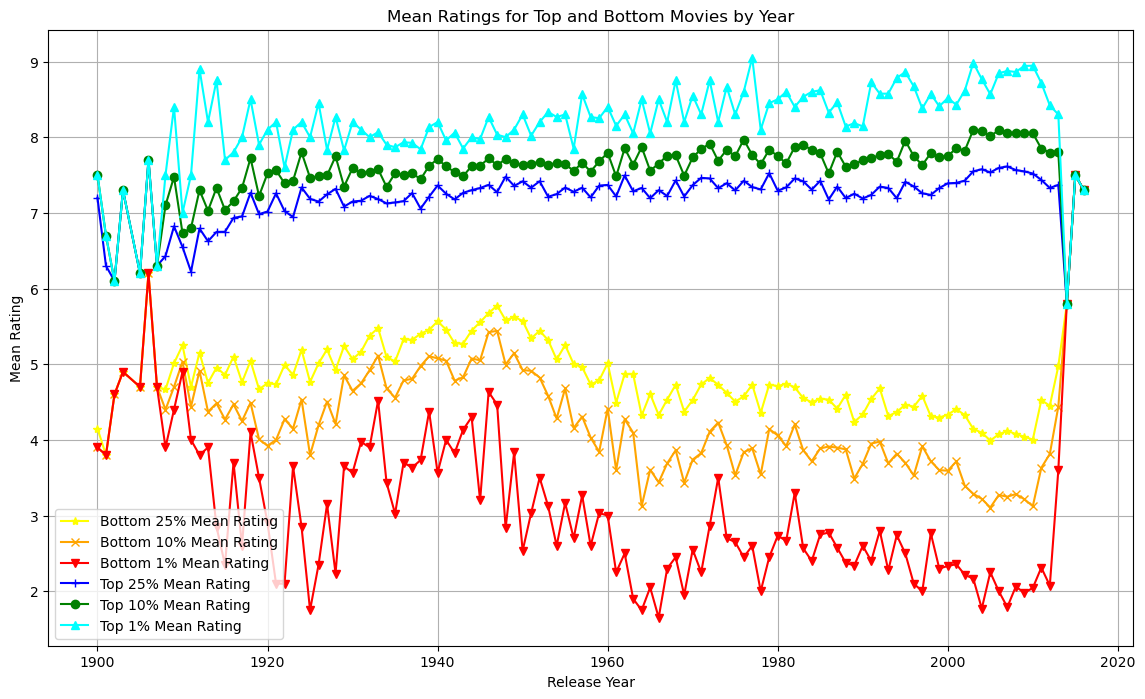

In [25]:
# Define a function to calculate mean for top 10%, bottom 10%, top 1%, and bottom 1%
def quantile_means(group):
    top_25_cutoff = group['averageRating'].quantile(0.75)  # Top 25% cutoff
    bottom_25_cutoff = group['averageRating'].quantile(0.25)  # Top 10% cutoff
    top_10_cutoff = group['averageRating'].quantile(0.9)  # Top 10% cutoff
    bottom_10_cutoff = group['averageRating'].quantile(0.1)  # Bottom 10% cutoff
    top_1_cutoff = group['averageRating'].quantile(0.99)  # Top 1% cutoff
    bottom_1_cutoff = group['averageRating'].quantile(0.01)  # Bottom 1% cutoff

    top_25_mean = group[group['averageRating'] >= top_25_cutoff]['averageRating'].mean()
    bottom_25_mean = group[group['averageRating'] <= bottom_25_cutoff]['averageRating'].mean()
    top_10_mean = group[group['averageRating'] >= top_10_cutoff]['averageRating'].mean()
    bottom_10_mean = group[group['averageRating'] <= bottom_10_cutoff]['averageRating'].mean()
    top_1_mean = group[group['averageRating'] >= top_1_cutoff]['averageRating'].mean()
    bottom_1_mean = group[group['averageRating'] <= bottom_1_cutoff]['averageRating'].mean()

    return pd.Series({
        'top_25_mean': top_25_mean,
        'bottom_25_mean': bottom_25_mean,
        'top_10_mean': top_10_mean,
        'bottom_10_mean': bottom_10_mean,
        'top_1_mean': top_1_mean,
        'bottom_1_mean': bottom_1_mean
    })

# Group by release year and apply the function
rating_quantiles = rat.groupby('Movie release date').apply(quantile_means)

# Extract years and the means
years = rating_quantiles.index
top_25_means = rating_quantiles['top_25_mean']
bottom_25_means = rating_quantiles['bottom_25_mean']
top_10_means = rating_quantiles['top_10_mean']
bottom_10_means = rating_quantiles['bottom_10_mean']
top_1_means = rating_quantiles['top_1_mean']
bottom_1_means = rating_quantiles['bottom_1_mean']

# Plot the results
plt.figure(figsize=(14, 8))
plt.plot(years, bottom_25_means, label='Bottom 25% Mean Rating', marker='*', color='yellow')
plt.plot(years, bottom_10_means, label='Bottom 10% Mean Rating', marker='x', color='orange')
plt.plot(years, bottom_1_means, label='Bottom 1% Mean Rating', marker='v', color='red')
plt.plot(years, top_25_means, label='Top 25% Mean Rating', marker='+', color='blue')
plt.plot(years, top_10_means, label='Top 10% Mean Rating', marker='o', color='green')
plt.plot(years, top_1_means, label='Top 1% Mean Rating', marker='^', color='cyan')
plt.xlabel('Release Year')
plt.ylabel('Mean Rating')
plt.title('Mean Ratings for Top and Bottom Movies by Year')
plt.legend()
plt.grid()
plt.show()

We can see that the best movies of each year are all following a similar trend and are quite stable. The bad ones on the other side are changing a lot over time, in a range of 10 years arounf 1940 there were a few very bad movies, while in the 60s there were a lot of bad movies, which turns the mean down. 

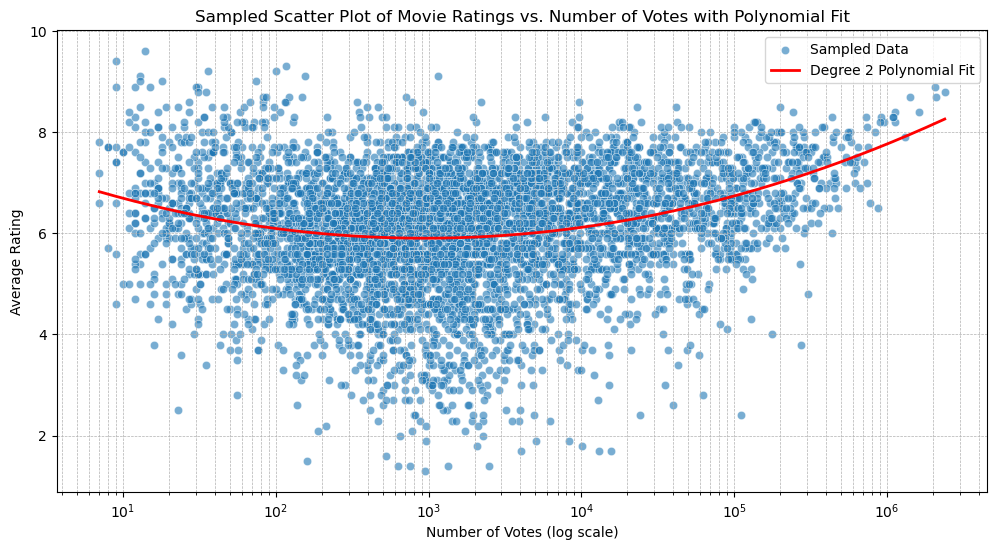

In [44]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

# Filter out rows where numVotes <= 0
sampled_rat = rat[rat['numVotes'] > 0].sample(frac=0.2, random_state=42)  # Sample 1% for better results

# Fit a degree-2 polynomial
x = np.log10(sampled_rat['numVotes'])
y = sampled_rat['averageRating']
coeffs = np.polyfit(x, y, deg=2)  # Fit polynomial of degree 2
poly = np.poly1d(coeffs)

# Generate smooth x values for plotting the polynomial
x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = poly(x_smooth)

# Plot the scatterplot with the fitted polynomial
plt.figure(figsize=(12, 6))
sns.scatterplot(data=sampled_rat, x='numVotes', y='averageRating', alpha=0.6, label="Sampled Data")
plt.plot(10**x_smooth, y_smooth, color='red', label="Degree 2 Polynomial Fit", linewidth=2)

# Set x-axis to log scale
plt.xscale('log')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Average Rating')
plt.title('Sampled Scatter Plot of Movie Ratings vs. Number of Votes with Polynomial Fit')
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_14580\84646600.py:29: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(x, y, deg=2)


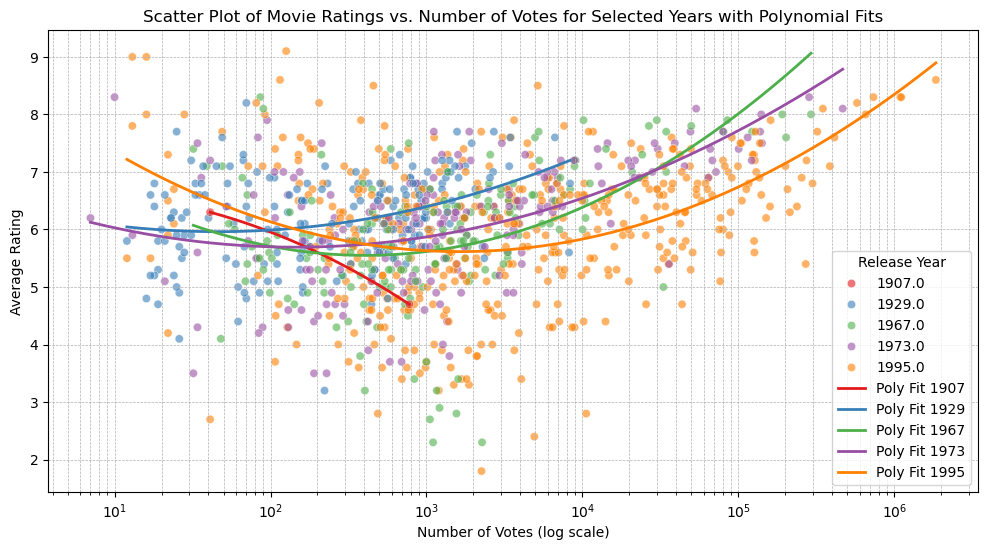

In [ ]:


# List of years to filter
selected_years = [1907, 1929, 1967, 1973, 1995]

# Filter the DataFrame to include only movies from the selected years
filtered_rat = rat[rat['Movie release date'].isin(selected_years)]

# Create a color palette based on the unique years
palette = sns.color_palette("Set1", n_colors=len(selected_years))

# Plot the scatterplot for the selected years with unique colors for each year
plt.figure(figsize=(12, 6))
sns.scatterplot(data=filtered_rat, x='numVotes', y='averageRating', 
                hue='Movie release date', palette=palette, alpha=0.6)

# Fit and plot a degree-2 polynomial for each selected year
for year in selected_years:
    # Filter the data for the current year
    year_data = filtered_rat[filtered_rat['Movie release date'] == year]
    
    # Log-transform 'numVotes' for better fitting in the log scale
    x = np.log10(year_data['numVotes'])
    y = year_data['averageRating']
    
    # Fit a degree-2 polynomial (quadratic)
    coeffs = np.polyfit(x, y, deg=2)
    poly = np.poly1d(coeffs)
    
    # Generate smooth x values for the fitted curve
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = poly(x_smooth)
    
    # Plot the polynomial curve
    plt.plot(10**x_smooth, y_smooth, label=f'Poly Fit {year}', color=palette[selected_years.index(year)], linewidth=2)

# Set log scale for x-axis
plt.xscale('log')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Movie Ratings vs. Number of Votes for Selected Years with Polynomial Fits')
plt.legend(title='Release Year')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()


This graph is interesting, if we can make it usable in the website when people can select 2 (or more) years and compare them in this plot would be very nice (We don't absolutely need the polynomials, it was just to try to see the difference between the years) 

ALSO COMPARE TWO PERIODS -> MORE DATA TO VIZUALIZE

In [57]:
rat['Movie runtime'].describe()

count    2.671000e+04
mean     1.300422e+02
std      6.603466e+03
min      5.000000e-01
25%      8.000000e+01
50%      9.100000e+01
75%      1.030000e+02
max      1.079281e+06
Name: Movie runtime, dtype: float64

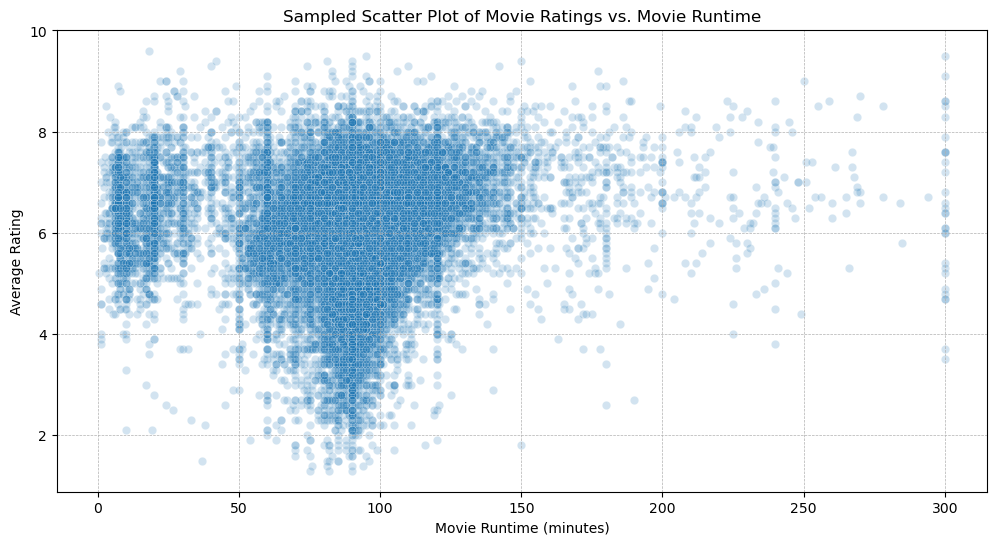

count    24023.000000
mean        89.294706
std         31.535132
min          0.500000
25%         80.000000
50%         91.000000
75%        102.000000
max        300.000000
Name: Movie runtime, dtype: float64

In [70]:
# Clip the values to be between 0 and 200
rat['Movie runtime'] = rat['Movie runtime'].clip(0, 300)

sampled_rat = rat.sample(frac=0.9, random_state=42)

plt.figure(figsize=(12, 6))
sns.scatterplot(data=sampled_rat, x='Movie runtime', y='averageRating', alpha=0.2)
plt.xlabel('Movie Runtime (minutes)')
plt.xscale('linear')
plt.ylabel('Average Rating')
plt.title('Sampled Scatter Plot of Movie Ratings vs. Movie Runtime')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.show()
sampled_rat['Movie runtime'].describe()

Not really useful as a graph, can't make a lot out of it

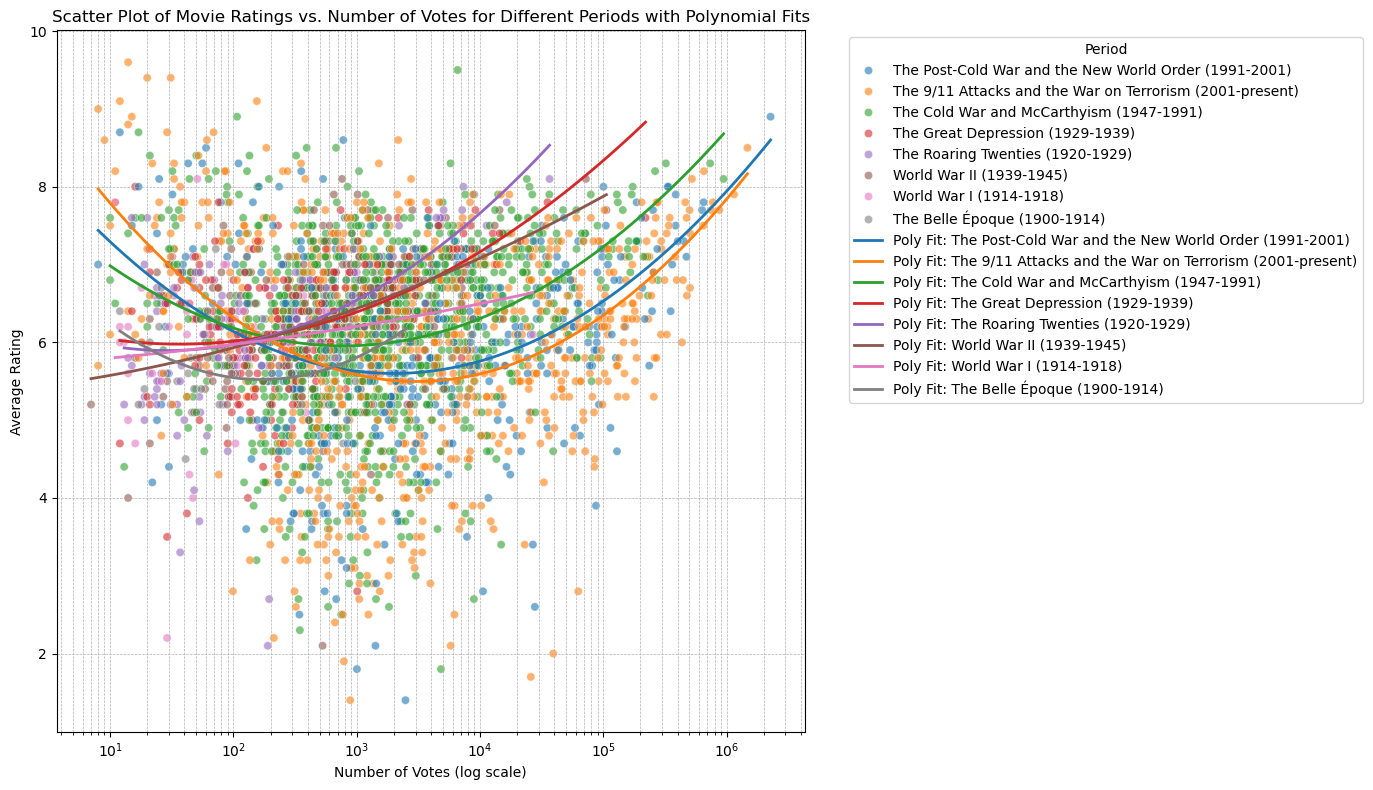

In [74]:
periods_map = {
    "The Belle Époque (1900-1914)": {"start_year": 1900, "end_year": 1914},
    "World War I (1914-1918)": {"start_year": 1914, "end_year": 1919},
    "The Roaring Twenties (1920-1929)": {"start_year": 1920, "end_year": 1929},
    "The Great Depression (1929-1939)": {"start_year": 1929, "end_year": 1939},
    "World War II (1939-1945)": {"start_year": 1939, "end_year": 1946},
    "The Cold War and McCarthyism (1947-1991)": {"start_year": 1947, "end_year": 1991},
    "The Civil Rights and Social Equality Struggles (1950s-1970s)": {"start_year": 1950, "end_year": 1970},
    "The Reagan Years and the Rise of Neoliberalism (1980s)": {"start_year": 1980, "end_year": 1989},
    "The Post-Cold War and the New World Order (1991-2001)": {"start_year": 1991, "end_year": 2001},
    "The 9/11 Attacks and the War on Terrorism (2001-present)": {"start_year": 2001, "end_year": 2024},
}

# Assign a period label to each movie based on its release year
def assign_period(year):
    for period, bounds in periods_map.items():
        if bounds["start_year"] <= year <= bounds["end_year"]:
            return period
    return None

# Add a 'Period' column to the DataFrame
rat['Period'] = rat['Movie release date'].apply(assign_period)

# Filter to include only movies in the defined periods
filtered_rat = rat[rat['Period'].notna()]
filtered_rat = filtered_rat.sample(frac=0.1)

# Create a color palette based on the unique periods
unique_periods = filtered_rat['Period'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_periods))

# Plot the scatterplot for the selected periods with unique colors for each period
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_rat, x='numVotes', y='averageRating', 
                hue='Period', palette=palette, alpha=0.6)

# Fit and plot a degree-2 polynomial for each period
for i, period in enumerate(unique_periods):
    # Filter the data for the current period
    period_data = filtered_rat[filtered_rat['Period'] == period]
    
    # Log-transform 'numVotes' for better fitting in the log scale
    x = np.log10(period_data['numVotes'])
    y = period_data['averageRating']
    
    # Fit a degree-2 polynomial (quadratic)
    if len(x) > 2:  # Ensure there are enough data points to fit a polynomial
        coeffs = np.polyfit(x, y, deg=2)
        poly = np.poly1d(coeffs)
        
        # Generate smooth x values for the fitted curve
        x_smooth = np.linspace(x.min(), x.max(), 500)
        y_smooth = poly(x_smooth)
        
        # Plot the polynomial curve
        plt.plot(10**x_smooth, y_smooth, label=f'Poly Fit: {period}', 
                 color=palette[i], linewidth=2)

# Set log scale for x-axis
plt.xscale('log')
plt.xlabel('Number of Votes (log scale)')
plt.ylabel('Average Rating')
plt.title('Scatter Plot of Movie Ratings vs. Number of Votes for Different Periods with Polynomial Fits')
plt.legend(title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Cool result we can use to compare periods !

# a faire encore:

- ratings in fct of theme (when lilly-flore is done)